# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>


## Применение лесов для детектирования аномалий, часть 2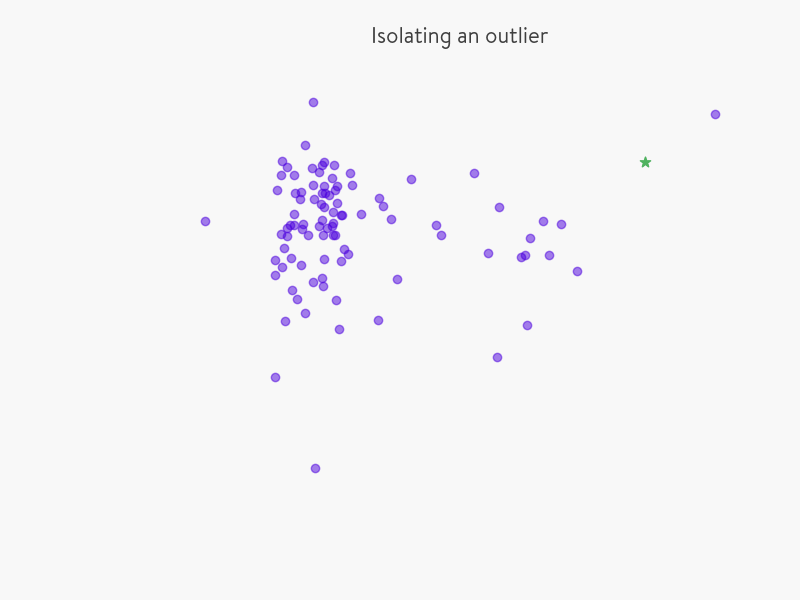

# Использование статистики для обнаружения аномалий


В простейшем виде выброс или аномалия представляют собой наблюдение, которое существенно отличается от других наблюдений в выборке. Степень отклонения и метод его обнаружения могут вызывать споры в зависимости от используемого подхода. В данной статье мы придерживаемся правила 68–95–99,7, основанного на предположении о нормальном (гауссовском) распределении.

Нарушение этого правила подразумевает следующее:

*   68% данных должны лежать в пределах одного стандартного отклонения от среднего значения генеральной совокупности.
*   95% данных должны лежать в пределах двух стандартных отклонений от среднего значения генеральной совокупности.
*   99,7% данных должны лежать в пределах трех стандартных отклонений от среднего значения генеральной совокупности.
*   Любые данные за пределами этих диапазонов существенно отклоняются от среднего значения совокупности и рассматриваются как выбросы или аномалии.

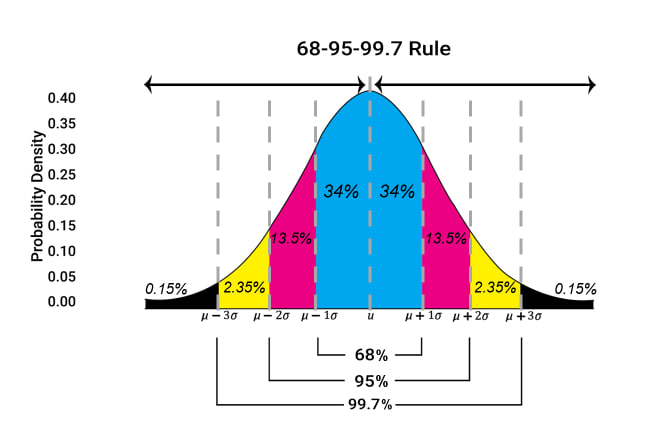

**Значит, все выбросы плохие?**

**Нет!** Выбросы — это просто точки, которые отклоняются от среднего значения генеральной совокупности. Могут быть очень веские причины, по которым могут существовать выбросы. Например, может случиться так, что для определенного магазина в течение дня действует скидка 50%, что приведет к заметному увеличению продаж в отличие от обычного поведения магазина, где все остальные дни не являются днями скидок. Это будет помечено как выброс, но это не плохо, это просто указывает на аномальную распродажу в магазине.

Выбросы также очень информативны. Когда генерируется точка данных, которая явно отличается от нормы, первый вопрос который вы себе должны задать - **Почему?**

Давайте рассмотрим другой случай. В обрабатывающей промышленности или тяжелом машиностроении датчики размещаются над различным технологическим оборудованием на действующих объектах. Инженеры и аналитики данных будут отслеживать эти тенденции, чтобы выявить отклонения (за пределами стандартного рабочего диапазона), указывающие на то, что что-то не так.

Скажем, у нас есть линия смешивания для химического производства 🧪🧪🧪.

Представьте себе, что один из моторов, отвечающий за смешивание химикатов в чане, внезапно глохнет и отключается.

## Общий осмотр данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (20,5)

Отрисуйте на одном графике временной ряд для всех показателей мотора:

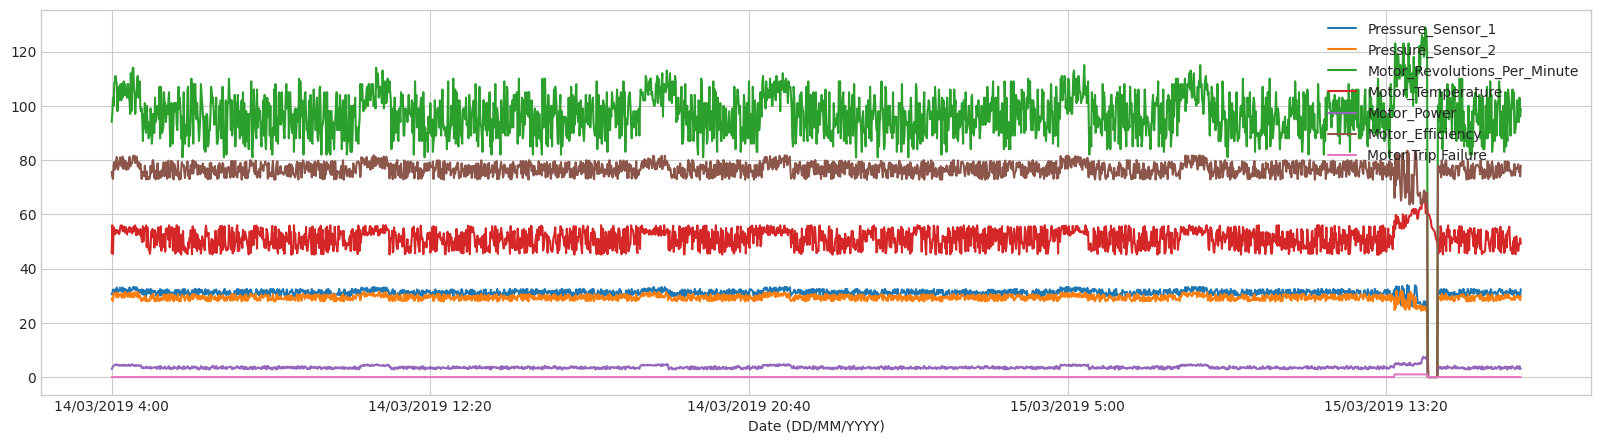

In [ ]:
<...>

***Что вы можете сказать про наблюдаемые графики?***

**Ответ:** <...>

Скорее всего данные, которые вы анализируете, не соответствуют стандартному нормальному распределению.
В таком случае мы можем использовать метод межквартильного размаха (IQR) для простой идентификации выбросов или аномалий.

$IQR = Q3 - Q1$

Lower_Limit $= Q1 - 1.5 * IQR$

Upper_Limit $= Q3 + 1.5 * IQR$

Anomaly = Any Value < Lower Limit OR Any Value > Upper Limit

Попробуйте объяснить, почему используется именно коэффицент 1.5 перед IQR?

**Ответ:** <...>

## Использование лесов для обнаружения аномалий

In [ ]:
!pip install adtk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (20,5)
from sklearn.ensemble import IsolationForest

Большинство методов обнаружения аномалий включают в себя построение "распределения" нормального поведения, а затем обучение "модели" или установление порога для выявления периодов, которые не соответствуют этому определению "нормальности". В изоляционных лесах используется принципиально иной подход; Изоляционные леса - это бинарные деревья, оптимизированные специально для изоляции и выявления аномалий (то есть аномальные точки данных находятся дальше от обычных наблюдений в пространстве объектов и имеют меньшую среднюю глубину).

При использовании дерева изоляции разделение экземпляров повторяется рекурсивно, пока все экземпляры не будут изолированы. Такое случайное разделение приводит к заметно более коротким путям для аномалий, поскольку:

1. Меньшее количество аномалий приводит к меньшему количеству разделов и, следовательно, к более коротким путям в древовидной структурe.
2. Экземпляры с различимыми значениями атрибутов с большей вероятностью будут разделены на раннем этапе секционирования.

Следовательно, когда лес случайных деревьев совместно создает более короткие пути для некоторых конкретных точек, они с высокой вероятностью являются аномалиями.

Подводя итоги, дерево изоляции стремится случайным образом выбрать объект (X), разделить его, а затем рекурсивно выбрать случайное значение разделения между минимальным и максимальным значением выбранного объекта, чтобы больше не было возможности разделения и каждое значение X было изолировано.

Проще говоря, для результирующих значений оценки аномалий:

- Если значение близко к 1, точка данных, скорее всего, является аномалией.
- Если значение меньше 0,5, то точка данных, скорее всего, будет обычной точкой.

Примечание: Вы можете выбрать порог аномалии, который вы хотите использовать для классификации точки как аномальной или нет.

**Первый этап - создание модели и импорт данных**

В данной задаче вы будете работать с данными по химическому оборудованию. Всего в датасете 6 ключевых сигналов, которые демонстрируют аномальное поведение непосредственно перед тем, как оборудование выходило из строя. Было выявлено, что мощность (Motor_Power) демонстрирует аномальное поведение, которое мы хотели бы выявить на ранней стадии.

In [ ]:
df = pd.read_csv(r'/content/Time_Series_Chemical_Machinery_Dataset.csv', index_col="Date (DD/MM/YYYY)",parse_dates=True, dayfirst=True)
X = df[['Motor_Power']]
motor_power = (X['Motor_Power'].values.reshape(-1,1))

Посмотрим на наши данные:

In [ ]:
<...>

,Pressure_Sensor_1,Pressure_Sensor_2,Motor_Revolutions_Per_Minute,Motor_Temperature,Motor_Power,Motor_Efficiency,Motor Trip Failure
Date (DD/MM/YYYY),,,,,,,
2019-03-14 04:00:00,30.702663,29.010453,94,45.62,2.93,75.69,0
2019-03-14 04:01:00,30.384615,28.278746,97,55.93,3.30,73.78,0
2019-03-14 04:02:00,32.233728,27.993031,103,45.40,3.94,73.04,0
2019-03-14 04:03:00,31.545858,30.919861,100,55.23,4.14,77.55,0
2019-03-14 04:04:00,32.233728,30.954704,108,54.51,4.37,79.24,0


Создайте и обучите модель изоляционного леса

In [ ]:
<...>

IsolationForest()

Сделайте предсказание вероятности аномальности точки с помощью метода `.score_samples`

In [ ]:
X['anomaly_scores'] = <...>

Также сделайте итоговое предсказание с помощью метода `.predict`

In [ ]:
X['anomaly_classification'] = <...>

Теперь вы можете заметить особенность метода `.score_samples` в библиотеке sklearn.

Ранее мы утверждали, что лес изоляции будет возвращать оценку в диапазоне от 0 до 1, где значения, близкие к 1, считаются аномальными, а значения < 0.5 считаются "нормальными".

Однако здесь вы увидите, что значения, возвращаемые sklearn, имеют формат отрицательных чисел. В этом случае это просто означает, что нам нужно инвертировать значения для интерпретации. То есть значения < -0.5 являются более "нормальными", а значения, превышающие порог -0.5, с большей вероятностью будут аномальными.

Посмотрим на полученные предсказания:

In [ ]:
<...>

,Motor_Power,anomaly_scores,anomaly_classification
Date (DD/MM/YYYY),,,
2019-03-14 04:00:00,2.93,-0.508312,-1
2019-03-14 04:01:00,3.30,-0.433055,1
2019-03-14 04:02:00,3.94,-0.463588,1
2019-03-14 04:03:00,4.14,-0.485781,1
2019-03-14 04:04:00,4.37,-0.489143,1


Используя стандартные пороговые значения, установленные в нашем лесу изоляции (т.е. 0.5), давайте оценим, насколько точно наш лес изоляции выявляет эти аномальные точки данных.

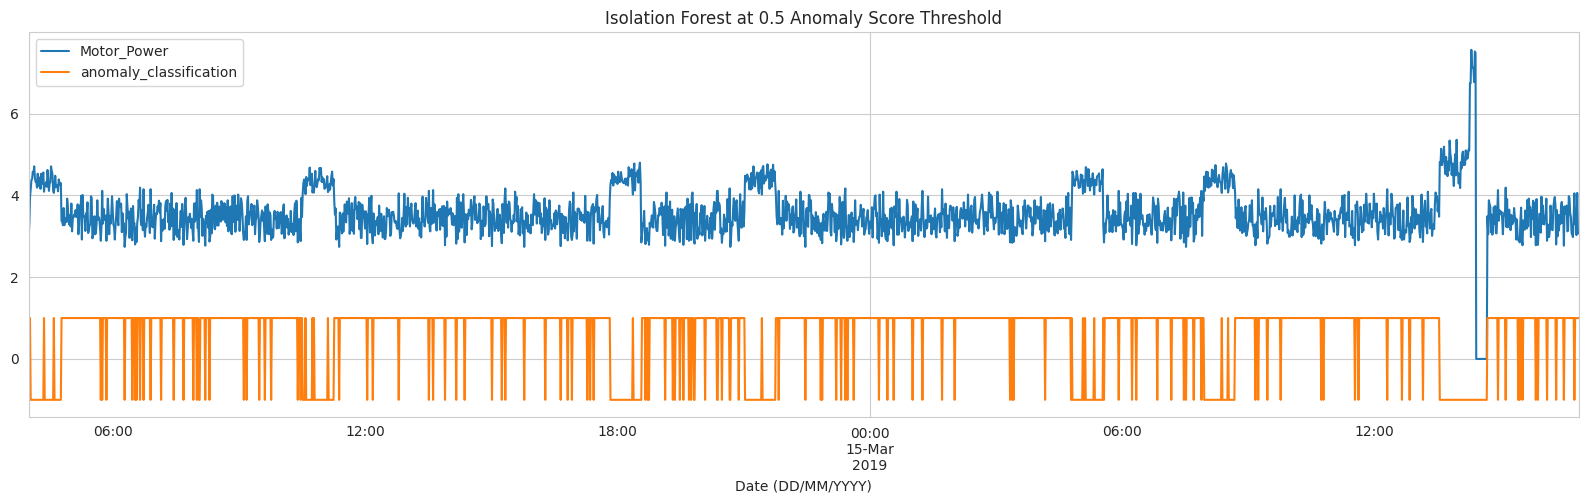

In [ ]:
X[['Motor_Power','anomaly_classification']].plot()
plt.title("Isolation Forest at 0.5 Anomaly Score Threshold")
plt.show()

***По наблюдениям сделайте вывод о пригодности данного порога для решения этой задачи:***

**Ответ:** <...>

Попробуйте выставить другой порог детектирования, который лучше подойдет для наших данных:

Text(0.5, 1.0, 'Isolation Forest at another Anomaly Score Threshold')

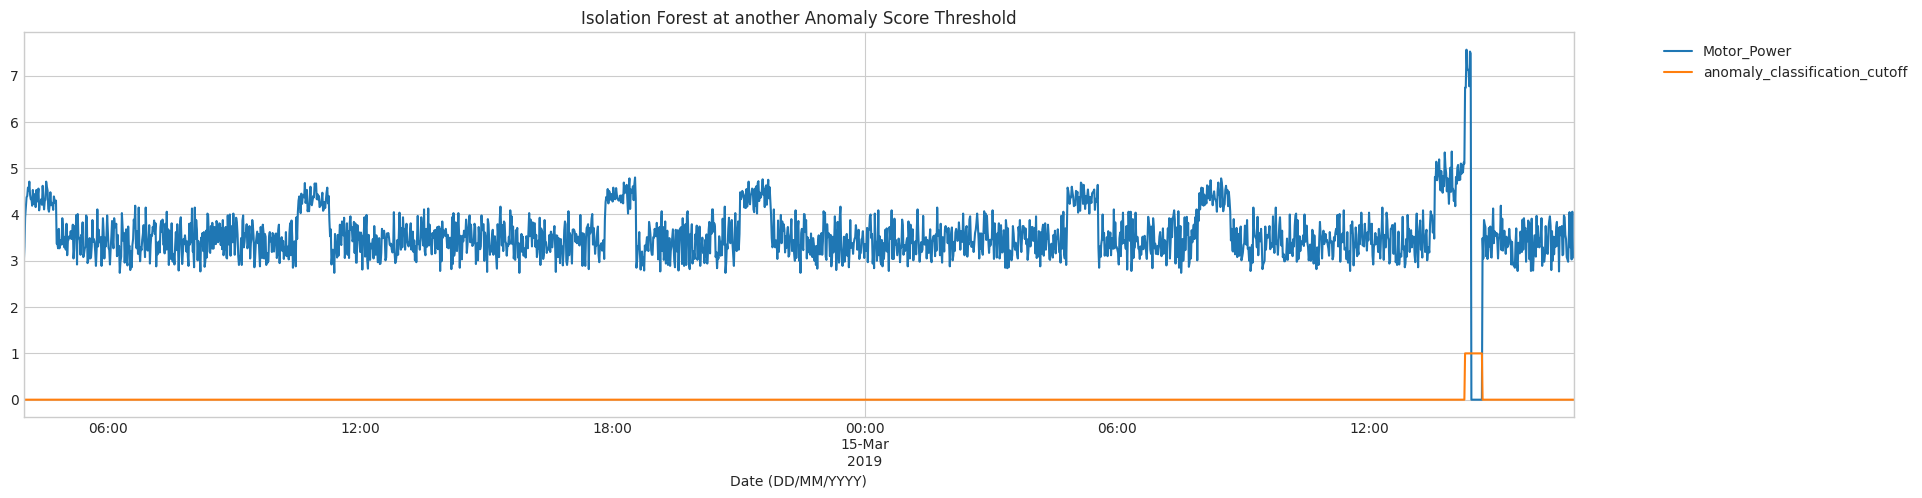

In [ ]:

cutoff = <...> #введите выбранный порог

X['anomaly_classification_cutoff'] = np.where(X['anomaly_scores']<-cutoff,1,0)
X[['Motor_Power','anomaly_classification_cutoff']].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Isolation Forest at another Anomaly Score Threshold")


Теперь сравним нашу реализацию с уже готовой реализацией метода IQR в библиотеке adtk:

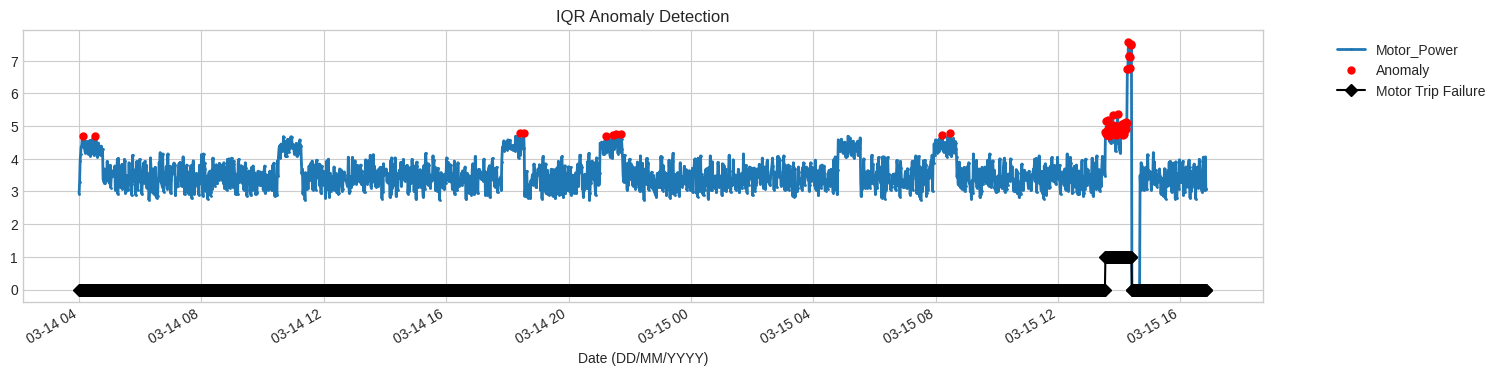

In [ ]:
from adtk.detector import InterQuartileRangeAD
from adtk.visualization import plot

iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(df['Motor_Power'])
plot(df['Motor_Power'], anomaly=anomalies, ts_linewidth=2, ts_markersize=2, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
df['Motor Trip Failure'].plot(color='black', marker="D", linewidth=1.5)
plt.title("IQR Anomaly Detection")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Сделайте выводы:

**Ответ:** <...>